In [1]:
sizes = [(2,2), (2,3),  (2,4),  (3,3),  (2,5),
         (2,6), (3,4),  (2,7),  (3,5),  (2,8),
         (4,4), (2,9),  (3,6),  (2,10), (4,5),
         (3,7), (2,11), (2,12), (3,8),  (4,6)]

In [2]:
import numpy as np
import qat
from qat.core import Schedule
#from qat.qpus import AnalogQPU
from qlmaas.qpus import AnalogQPU

from time import time
import pickle

from qat.core.variables import Variable, heaviside

def create_waveform(times, values):
    """
    A Funnction allowing us to concatenate many lines, limited by heavisides,
    thus creating a continuous, kinked line.
    """
    assert len(times) == len(values)
    # Store the final line as an ArithExpression
    arith_expr = 0
    t_var = Variable("t")
    # A line between each two points
    for entry_i in range(1, len(times)):
        # Create ax + b by calculating the slope and the offset
        a = (values[entry_i] - values[entry_i - 1]) / (times[entry_i] - times[entry_i - 1])
        b = ((values[entry_i] + values[entry_i - 1]) - a * (times[entry_i] + times[entry_i - 1])) / 2
        respective_line = a * t_var + b
        arith_expr += heaviside(t_var, times[entry_i - 1], times[entry_i]) * respective_line
    return arith_expr
#

def occ_op(nqbits, qi):
    ti = qat.core.Term(1.0, 'Z', [qi])
    return (1 + qat.core.Observable(nqbits, pauli_terms=[ti])) / 2
#

def setup_hamiltonian(L1, L2, R0, T_max, omega_max, Omega, delta, C6):
    nqbits = L1 * L2
    Ri = R0 * np.array(list(np.ndindex(L1, L2)))
    rij = np.array([np.linalg.norm(xi - xj)
                     for xi in Ri for xj in Ri]
                     ).reshape(nqbits, nqbits)
    np.fill_diagonal(rij, 1.0) # Avoid division by zero
    rij_inv = 1 / rij # Inverse of the distance matrix
    np.fill_diagonal(rij_inv, 0.0) # fill diagonal with zeros so it doens't contribute to the sum
    U = omega_max / 2
    omega_values = [0.0, omega_max , omega_max , 0]
    times = [0.0, 0.25, 0.5, T_max]
    omega_waveform = create_waveform(times, omega_values)
    # The waveform of the detuning Delta - for the 'n' terms
    delta_start = -6 * U
    delta_end = 2 * U # R_blockade is taken as 7.5
    delta_values = [delta_start, delta_start, delta_end, delta_end]
    delta_waveform = create_waveform(times, delta_values)
    #
    H1_terms = [qat.core.Term(1.0, "X", [i]) for i in range(nqbits)]
    H1 = qat.core.Observable(nqbits, pauli_terms=H1_terms)
    H2_terms = [qat.core.Term(-1.0, "Z", [i]) for i in range(nqbits)]
    H2 = qat.core.Observable(nqbits, pauli_terms=H2_terms)
    H3 = 0
    for i in range(nqbits):
        for j in range(i + 1, nqbits):
            H3 += (C6 * rij_inv[i, j]**6) * occ_op(nqbits, i) * occ_op(nqbits, j)

    schedule = Schedule(drive=[
        (omega_waveform / 2, H1),
        (delta_waveform, H2),
        (1, H3),], tmax=T_max)
    # schedule.display()
    return schedule



# testing timescales.
t1 = time()

L1, L2 = 3, 2
nqbits = L1 * L2
R0 = 6.0
# qsqr = qse.utils.squarelattice(6.0, L1, L2)

params = {
    'L1': L1,                # Number of qubits in the first dimension
    'L2': L2,                # Number of qubits in the second dimension
    'R0': 6.0,               # Lattice spacing
    'T_max': 0.6,            # The waveform of Omega - for the sigma_x terms
    'omega_max': 1.73144604, # from pulser_myqlm rad/µs
    'Omega': 1.2,            # Amplitude
    'delta': 2.0,            # detuning
    'C6': 1.5                # interaction scale
}

ff = open('times.dat', 'w')
ss = "        L1          L2    2^nqbits   veclength      tprep    tjob     tprocess"
ff.write(ss + '\n')
print(ss)
for L1, L2 in sizes:
    params['L1'] = L1
    params['L2'] = L2
    nqbits = L1 * L2
    schedule = setup_hamiltonian(**params)
    job = schedule.to_job()
    t2 = time()
    tprep = t2 - t1 # print(f"Time in problem setup: {t2 - t1}")

    t1 = time()
    my_qpu = AnalogQPU()
    async_result = my_qpu.submit(job)
    result = async_result.join()
    t2 = time()
    tjob = t2 - t1 # print(f"Time quantum job: {t2 - t1}")
    t1 = time()
    veclen = len(result)
    probs = np.fromiter((sample.probability for sample in result), dtype=float)
    coeff = np.fromiter((sample.amplitude for sample in result), dtype=complex)
    basis = np.fromiter((sample.state.int for sample in result), dtype=int)
    print(len(probs), len(coeff), len(basis))
    pickle.dump((L1, L2, coeff), open('quantum-data-' + str(L1) + 'x' + str(L2) + '.pkl', 'wb'))
    t2 = time()
    tpros = t2 - t1 # print(f"Time processing vecs : {t2 - t1}")
    ss = f"{L1:10}\t {L2:10}\t {2**nqbits:10}\t {veclen:10}\t {tprep:.5}\t {tjob:.5}\t {tpros:.5}"
    print(ss)
    ff.write(ss + '\n')

ff.close()

using legacy validation callback


        L1          L2    2^nqbits   veclength      tprep    tjob     tprocess
Submitted a new batch: QCJob2770
16 16 16
         2	          2	         16	         16	 0.0070052	 11.415	 0.0017998
Submitted a new batch: QCJob2771
64 64 64
         2	          3	         64	         64	 0.01731	 11.902	 0.00081992
Submitted a new batch: QCJob2772
256 256 256
         2	          4	        256	        256	 0.013589	 11.51	 0.001256
Submitted a new batch: QCJob2773
512 512 512
         3	          3	        512	        512	 0.027845	 10.893	 0.0024471
Submitted a new batch: QCJob2774
1024 1024 1024
         2	          5	       1024	       1024	 0.0351	 11.941	 0.002373
Submitted a new batch: QCJob2775
4095 4095 4095
         2	          6	       4096	       4095	 0.02945	 11.076	 0.011098
Submitted a new batch: QCJob2776
4095 4095 4095
         3	          4	       4096	       4095	 0.049561	 11.699	 0.011345
Submitted a new batch: QCJob2777
16278 16278 16278
         2	          7	    

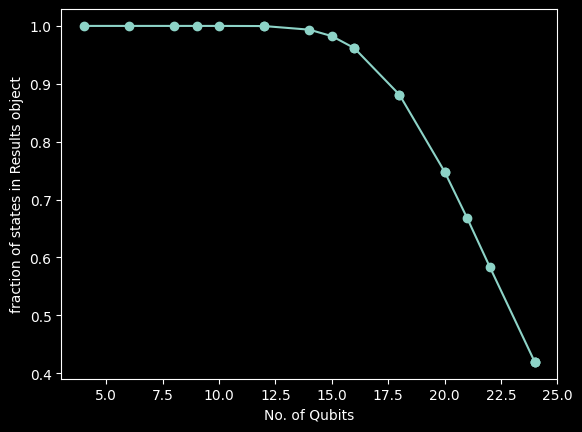

In [16]:
import matplotlib.pyplot as plt
import numpy as np
times = np.loadtxt('times.dat', skiprows=1).T
L1, L2, hs0, hs = times[0:4]
Ns = L1 * L2
plt.plot(Ns, hs/hs0, 'o-')
plt.xlabel("No. of Qubits")
plt.ylabel("fraction of states in Results object")
plt.show()